In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from imblearn.datasets import fetch_datasets

In [3]:
data = fetch_datasets()['mammography']

In [4]:
data

{'data': array([[ 0.23001961,  5.0725783 , -0.27606055,  0.83244412, -0.37786573,
          0.4803223 ],
        [ 0.15549112, -0.16939038,  0.67065219, -0.85955255, -0.37786573,
         -0.94572324],
        [-0.78441482, -0.44365372,  5.6747053 , -0.85955255, -0.37786573,
         -0.94572324],
        ...,
        [ 1.2049878 ,  1.7637238 , -0.50146835,  1.5624078 ,  6.4890725 ,
          0.93129397],
        [ 0.73664398, -0.22247361, -0.05065276,  1.5096647 ,  0.53926914,
          1.3152293 ],
        [ 0.17700275, -0.19150839, -0.50146835,  1.5788636 ,  7.750705  ,
          1.5559507 ]]),
 'target': array([-1, -1, -1, ...,  1,  1,  1]),
 'DESCR': 'mammography'}

In [5]:
X = pd.DataFrame(data['data'])

In [6]:
Y = pd.DataFrame(data['target'])

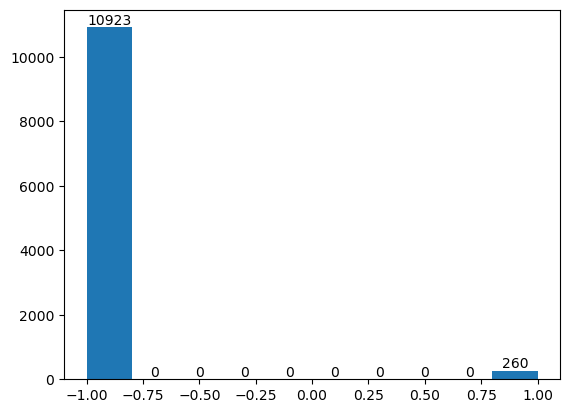

In [7]:
edges, lines, bins = plt.hist(Y)
plt.bar_label(bins)
plt.show()

In [8]:
X.shape

(11183, 6)

In [9]:
Y.shape

(11183, 1)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.25, stratify=Y)

In [12]:
X_train.shape

(8387, 6)

In [13]:
from imblearn.metrics import classification_report_imbalanced

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
def report(model, x, y, text="train"):
    print(f'{text} \t | \t Classification report for: {type(model).__name__}')
    
    y_pred = model.predict(x)
    
    print('-'*80)
    print(classification_report_imbalanced(y, y_pred))
    print('-'*80)
    print(pd.DataFrame(confusion_matrix(y, y_pred), index=['B', 'M'], columns=['B', 'M']))

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
model_dtc = DecisionTreeClassifier(max_depth=6, min_samples_split=50, criterion='gini')

In [18]:
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=50)

In [19]:
report(model_dtc, X_train, y_train)

train 	 | 	 Classification report for: DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.50      0.99      0.71      0.53      8192
          1       0.91      0.50      1.00      0.65      0.71      0.48       195

avg / total       0.99      0.99      0.51      0.99      0.71      0.53      8387

--------------------------------------------------------------------------------
      B   M
B  8182  10
M    97  98


In [20]:
report(model_dtc, X_test, y_test)

train 	 | 	 Classification report for: DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.38      0.99      0.62      0.41      2731
          1       0.68      0.38      1.00      0.49      0.62      0.36        65

avg / total       0.98      0.98      0.40      0.98      0.62      0.41      2796

--------------------------------------------------------------------------------
      B   M
B  2719  12
M    40  25


In [21]:
def resample(sampler, X, y):
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    return X_resampled, y_resampled

In [22]:
from sklearn.decomposition import PCA

In [31]:
def visualize(X, X_resampled, Y, Y_resampled, x_oppacity=0.5):
    pca = PCA(n_components=2)
    
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled)
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, Y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i+1)
        colors = ['b' if y==-1 else 'r' for y in Y_stacked[i]]
        alpha = [x_oppacity if y==-1 else 1-x_oppacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:,0], X_stacked[i][:, 1], c=colors, alpha=alpha)
        plt.title(f'{"After" if i else "Before"}', c='blue' if i else 'green')
        
    plt.show()

In [25]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier(max_depth=7, min_samples_split=25, criterion='gini')
    model.fit(X_train, y_train)
    
    report(model, X_train, y_train)
    print()
    report(model, X_test, y_test, 'test')
    
    return model

In [26]:
# RandomOverSampler

In [27]:
from imblearn.over_sampling import RandomOverSampler

In [28]:
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')

In [29]:
X_res, y_res = resample(ros, X_train, y_train)

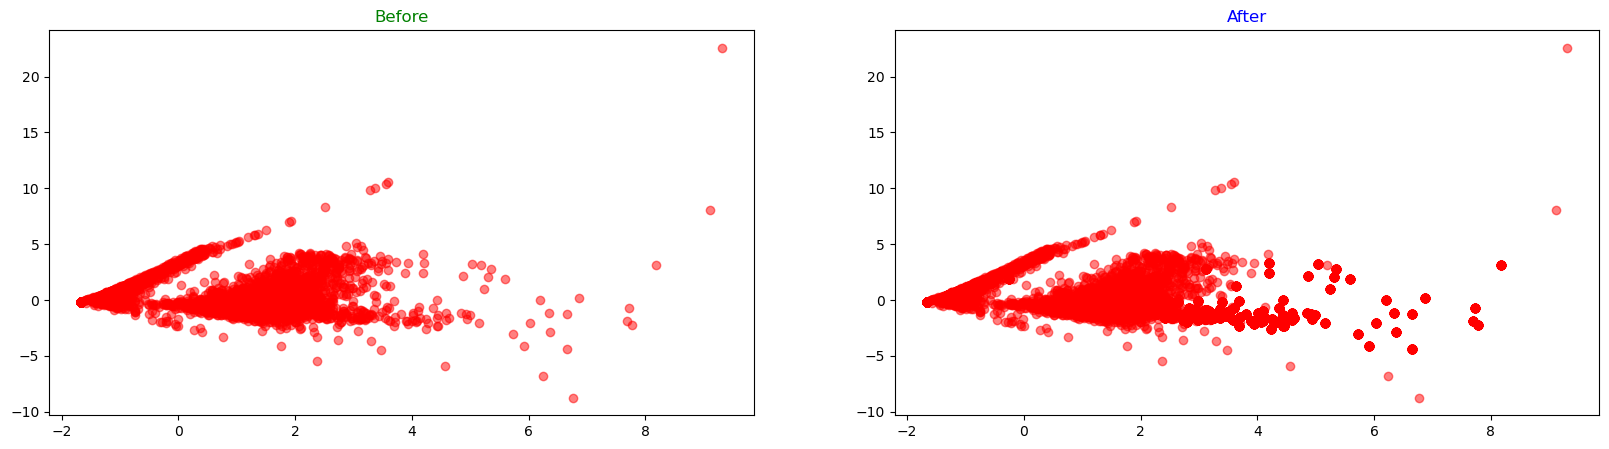

In [32]:
visualize(X_train, X_res, y_train, y_res)

In [33]:
model_ros = train_and_evaluate(X_res, y_res, X_test, y_test)

train 	 | 	 Classification report for: DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.97      0.96      0.97      0.97      0.97      0.93      8192
          1       0.96      0.97      0.96      0.97      0.97      0.94      8192

avg / total       0.97      0.97      0.97      0.97      0.97      0.94     16384

--------------------------------------------------------------------------------
      B     M
B  7893   299
M   242  7950

test 	 | 	 Classification report for: DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.96      0.85      0.98      0.90      0.83      2731
          1       0.36      0.85      0.96      0.50      0.90      0.81        65

avg /

In [34]:
from imblearn.over_sampling import SMOTE

In [36]:
smote = SMOTE(k_neighbors=10, random_state=42)

In [37]:
X_res, y_res = resample(smote, X_train, y_train)

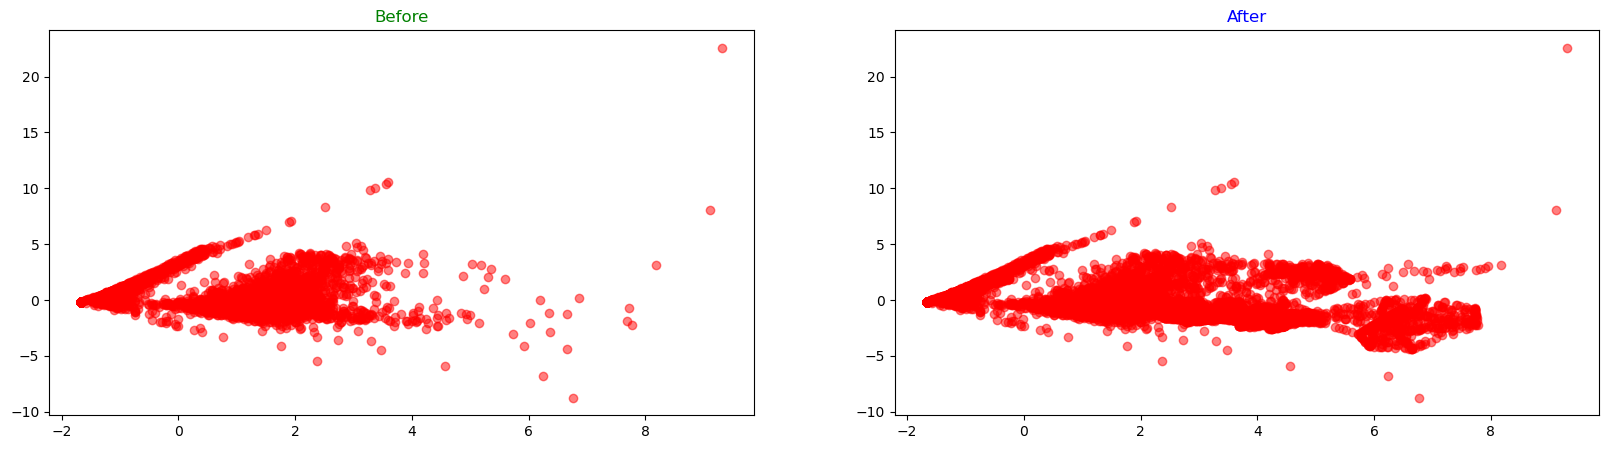

In [38]:
visualize(X_train, X_res, y_train, y_res)

In [39]:
model_smote = train_and_evaluate(X_res, y_res, X_test, y_test)

train 	 | 	 Classification report for: DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.95      0.96      0.95      0.95      0.95      0.91      8192
          1       0.96      0.95      0.96      0.95      0.95      0.91      8192

avg / total       0.95      0.95      0.95      0.95      0.95      0.91     16384

--------------------------------------------------------------------------------
      B     M
B  7862   330
M   426  7766

test 	 | 	 Classification report for: DecisionTreeClassifier
--------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.96      0.83      0.98      0.89      0.80      2731
          1       0.31      0.83      0.96      0.45      0.89      0.78        65

avg /